In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
})
plt.rcParams['font.size'] = 12

# Neural networks

***Summary: In this tutorial we will build and train a neural network***

Neural networks can be understood fundamentally as powerful tools for function approximation. They are structured to learn a mapping from inputs $x$ to outputs $y$, based on observed data. Whether the task is image classification, speech recognition, or solving differential equations, the central idea is the same: approximate an unknown function $f:\mathbb{R}^n \to \mathbb{R}^m$ that relates inputs to desired outputs.

A neural network achieves this by composing many simple parameterized functions (typically linear combinations of the input followed by nonlinear activations). With sufficient complexity (depth and width), neural networks are universal approximators: they can approximate any continuous function on a compact domain to arbitrary accuracy, assuming proper training. Neural networks then serve as flexible surrogates, learning from examples rather than requiring explicit modeling of the underlying system.

### The perceptron

In this tutorial we will focus primarily neural networks built from ensembles of a basic atomic unit known as the ***perceptron***. A perceptron takes a vector of real-values inputs, calculates a linear combination of these inputs, and then outputs $1$ if the results is greater than some arbitrary threshold and $0$ otherwise. More precisely, given inputs $x_1, \ldots, x_n$, the output of the perceptron $\sigma(x_1, \ldots, x_n)$ is:
$$
\sigma(x_1, \ldots, x_n; w_1, \ldots , w_n, b) = 
\begin{cases}
1, & \text{if } \sum_i w_i x_i + b > 0 \\
0, & \text{otherwise}
\end{cases}
$$
where $w_i$ are real-values constants or ***weights***, and $b$ represents an arbitrary threshold or ***bias*** which the sum of weighted inputs must surpass in order to return $1$. More compactly, defining $x_0 \equiv b, w_0 = 1$ the perceptron can be written simply as 
$$
\sigma(x_1, \ldots, x_n; w_1, \ldots , w_n, b) = \Theta \left(\sum_{i = 0}^n x_i w_i \right)
$$
where $\Theta$ is the heaviside theta function. 

We'll start by constructing a single perceptron with three inputs using our `Scalar` class built in the previous tutorial.

In [2]:
from engine import Scalar

In [3]:
def perceptron(x1, x2, x3, w1, w2, w3, b):
    """
    Assuming an input of three-scalar values
    """
    # Build the computation graph
    x1w1 = x1 * w1; x1w1.label = "x_1*w_1"
    x2w2 = x2 * w2; x2w2.label = "x_2*w_2"
    x3w3 = x3 * w3; x3w3.label = "x_3*w_3"

    # Weighted sum of inputs
    x1w1px2w2 = x1w1 + x2w2; x1w1px2w2.label = "sum_i=1^2 (x_i*w_i)"    
    x1w1px2w2px3w3 = x1w1px2w2 + x3w3; x1w1px2w2px3w3.label = "sum_i=1^3 (w_i*x_i)"

    # Adding the bias to the weighted sum of inputs
    x1w1px2w2px3w3pb = x1w1px2w2px3w3 + b; x1w1px2w2px3w3pb.label = "sigma"

    # Activation function
    sigma = x1w1px2w2px3w3pb.ifel(x1w1px2w2px3w3pb.data > 0.0, 1.0, 0.0); sigma.label = "Theta(sigma)"

    # Return the output of the perceptron
    return sigma

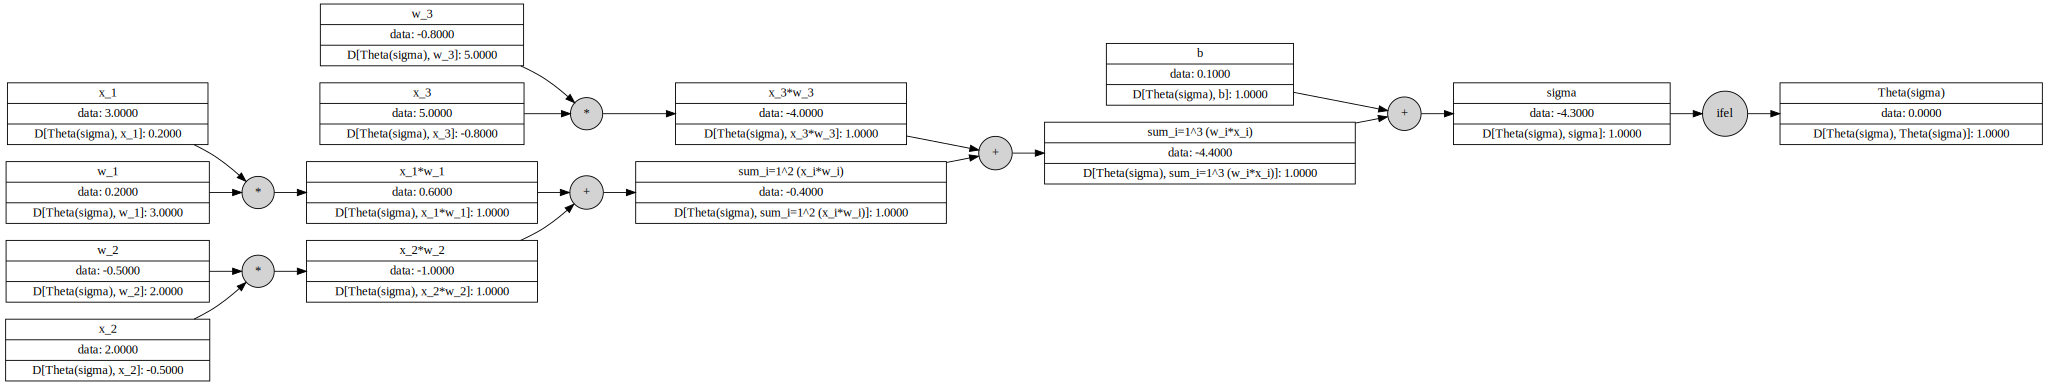

In [4]:
# Weights for each input
w1 = Scalar(0.2, label = "w_1")
w2 = Scalar(-0.5, label = "w_2")
w3 = Scalar(-0.8, label = "w_3")

x1 = Scalar(3.0, label = "x_1")
x2 = Scalar(2.0, label = "x_2")
x3 = Scalar(5.0, label = "x_3")

b = Scalar(0.1, label = "b")

# Construct the perceptron
sigma = perceptron(x1, x2, x3, w1, w2, w3, b)
# Perform the backwards pass
sigma.backward()
# Look at the computation graph
sigma.visualize_graph(output_label = "Theta(sigma)")

## Classifying <font color="red">red</font> vs <font color="blue">blue</font> with a single perceptron

We can try to get some intuition for the capabilities of a single perceptron through a simple classification task: 

*Given a dataset of RGB (Red, Green, Blue) values (with G = 0 for simplicity), distinguish red RGB values from blue RGB values.*

First we need to construct a dataset consisting of RGB values between (255,0,0) and (0,0,255).

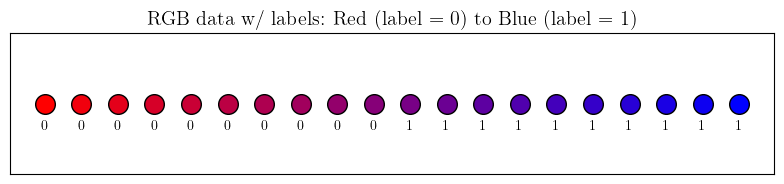

In [5]:
import numpy as np
# Create RGB values interpolating between red (255,0,0) and blue (0,0,255)
num_samples = 20
R = np.linspace(255, 0, num_samples, dtype = int)
G = np.zeros(num_samples, dtype=int)
B = np.linspace(0, 255, num_samples, dtype = int)

# Label: 0 for red (R > B), 1 for blue (B >= R)
labels = (B >= R).astype(int)

# Stack into dataset
dataset = np.column_stack((R, G, B, labels))

# Plot the spectrum with labels
fig, ax = plt.subplots(figsize = (8, 2))
for i in range(num_samples):
    color = (R[i]/255, G[i]/255, B[i]/255)
    ax.scatter(i, 0, color = color, s = 200, edgecolor = 'k')
    ax.text(i, -0.013, f"{labels[i]}", ha = 'center', va = 'top', fontsize = 10)

# Clear axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
# Set title
ax.set_title(r"RGB data w/ labels: Red (label = 0) to Blue (label = 1)")
fig.tight_layout()

In [6]:
def RB_dataset(num_samples = 20, seed = None):
    """
    Create a random dataset of normalized RGB values and binary (red or blue) labels.
    """
    # Initialize a seed
    if seed is not None: np.random.seed(seed)
    # Generate random RGB values
    R = np.random.random(num_samples)
    G = np.zeros(num_samples) # Green channel is always 0
    B = np.random.random(num_samples)

    # Label: 0 for red (R > B), 1 for blue (B >= R)
    labels = (B >= R).astype(int)

    # Stack into dataset
    RGB = np.column_stack((R, G, B, labels))

    # Shuffle dataset
    indices = np.random.permutation(num_samples)
    RGB = RGB[indices]

    # Stack into dataset
    return RGB

In [7]:
# Create a dataset with 
num_samples = 1000
RB = RB_dataset(num_samples, seed = 42)

# Get a feel for the dataset
print('Dataset shape:', RB.shape)
print('RGB value:', RB[0, 0:3], '\nLabel:', RB[0, 3])
print('R:', RB[0, 0], 'G:', RB[0, 1], 'B:', RB[0, 2])
print('First 10 elements of dataset:\n', RB[:10])

Dataset shape: (1000, 4)
RGB value: [0.96502691 0.         0.69503523] 
Label: 0.0
R: 0.9650269106665126 G: 0.0 B: 0.6950352288585532
First 10 elements of dataset:
 [[0.96502691 0.         0.69503523 0.        ]
 [0.24929223 0.         0.17389525 0.        ]
 [0.32367924 0.         0.17483863 0.        ]
 [0.66864322 0.         0.82248056 1.        ]
 [0.38089086 0.         0.93443603 1.        ]
 [0.72226693 0.         0.0991781  0.        ]
 [0.7948113  0.         0.8940992  1.        ]
 [0.79941588 0.         0.7655129  0.        ]
 [0.46077877 0.         0.51905979 1.        ]
 [0.35597268 0.         0.55536355 1.        ]]


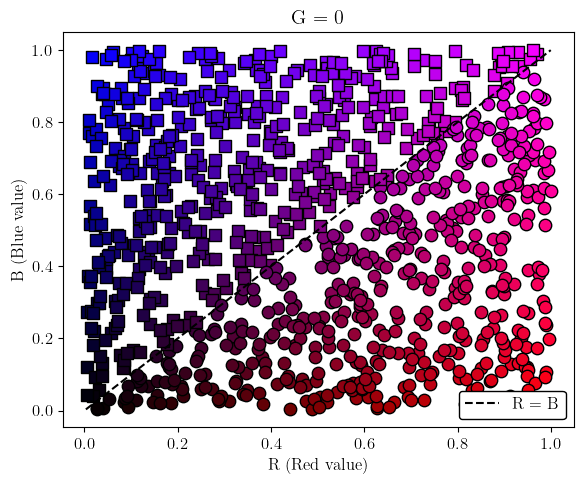

In [8]:
# We can also visualize the dataset
fig, ax = plt.subplots(figsize = (6, 5))
# Plot each point with its actual RGB color
for row in RB:
    R_val, G_val, B_val, label = row
    color = (R_val, G_val, B_val)
    marker = 'o' if label == 0 else 's'
    ax.scatter(R_val, B_val, c = [color], marker = marker, edgecolor = 'k', s = 80)

# Plot the decision boundary: R = B
min_val = min(RB[:, 0].min(), RB[:, 2].min())
max_val = max(RB[:, 0].max(), RB[:, 2].max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='R = B')

# Set labels and legend
ax.set_xlabel("R (Red value)")
ax.set_ylabel("B (Blue value)")
ax.set_title("G = 0")
ax.legend(framealpha = 1.0, edgecolor = 'black')
fig.tight_layout()

## Loss-ology

Arguably the most important decision when implementing machine learning algorithms is the choice of ***loss function***. Many, if not all, machine learning problems rely on the ability to be framed as an optimization problem that minimizes the loss. This should clarify and emphasize the importance of autodiff engines in machine learning. There are many loss functions, each tailored for a specific class of problem. 

For the task at hand, we have a single perceptron with three input values $x_1, x_2, x_3$ corresponding to RGB values and four tuneable weight parameters $w_1, w_2, w_3, b$. Based on the input, we want our perceptron to correctly predict a binary decision between red (0) and blue (1). 

Given a dataset of $x_i$ consisting of $N$ RGB color values, each with a label $c_i$ classifying red or blue - a naive ansatz for the loss may look something like
$$
\mathcal{L} = \sum_{i=1}^N \left(\sigma(x_i) - c_i\right)^2.
$$
What is the value of this function defined above? We can try to understand it based in two limits:
1. when the classifier is perfectly imperfect.
2. when the classifier is perfect.

In the former, $\mathcal{L} = N$, and in the latter, $\mathcal{L} = 0$. In other words, when the classifier perfectly identifies all colors in the dataset, the quantity $\mathcal{L}$ is at it's global minimum. As we discussed above, this is exactly the optimization function that we are looking for; minimizing $\mathcal{L}$ by varying the weights $w_i$ (via the gradient information provided by our autodiff engine) will push us towards an optimal classifier.

## Training


Given a loss, all that's left is to construct an optimization algorithm that will:

1. intialize the weights, 
2. reset the gradients of the weights to zero,
3. perform the forward-pass over the dataset (keeping track of the computation graph), 
4. perform the backward-pass, 
5. update the weights to minimize the loss and finally, 
6. repeat 1-4 many times over the full dataset a fixed number of times (or ***epochs***) or until the loss plateaus. 

The process outlined above is typically referred to as ***training*** the neural network.

In [9]:
import random

def train_perceptron(X, epochs = 50, lr = 1e-2, record_history = True):
    """
    Train a perceptron on the dataset X.
    X is expected to be an array of shape (N, 4) where the last column is the label.
    """
    # Extract the total number of samples in the dataset
    N = X.shape[0]
    # Randomly initialize weights and bias between -1 and 1
    weights = [Scalar(random.uniform(-1,1), label=f"w{i}") for i in range(3)]
    bias = Scalar(random.uniform(-1,1), label="b")

    # We can also record some metrics for training analysis
    if record_history:
        loss_history = []
        weight_history = [[w.data for w in weights]]
        bias_history = [bias.data]

    # Iterate over epochs
    for epoch in range(epochs):
        # Initialize total loss for the epoch
        total_loss = Scalar(0.0)
        for i in range(N):
            x1, x2, x3, label = X[i]
            prediction = perceptron(Scalar(x1), Scalar(x2), Scalar(x3), 
                               weights[0], weights[1], weights[2], bias)
            label = Scalar(label, label="label")
            # Compute the loss for a single value
            loss = (prediction - label)**2
            # Accumulate the total loss
            total_loss = total_loss + loss

        # Reset gradients before backpropagation
        for w in weights:
            w.grad = 0.0
        bias.grad = 0.0

        # Perform the backward pass
        total_loss.backward()

        # Update weights and bias
        for w in weights:
            w.data -= lr * w.grad
        bias.data -= lr * bias.grad

        # Record the loss and weights for analysis
        if record_history:
            loss_history.append(total_loss.data)
            weight_history.append([w.data for w in weights])
            bias_history.append(bias.data)

        # Output the loss for the epoch
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss.data}")
        
    return weights, bias, loss_history, weight_history, bias_history

In [10]:
# Define hyperparameters and train the perceptron
n_epochs = 50
learning_rate = 1e-2

weights, bias, loss_hist, weight_hist, bias_hist = train_perceptron(RB, epochs = n_epochs, lr = learning_rate)
#weights, bias = train_perceptron(X, num_epochs=10, learning_rate=1e-2)
print("Final Weights:", [w.data for w in weights])
print("Final Bias:", bias.data)

Epoch 1/50, Loss: 500.0
Epoch 2/50, Loss: 500.0
Epoch 3/50, Loss: 192.0
Epoch 4/50, Loss: 500.0
Epoch 5/50, Loss: 500.0
Epoch 6/50, Loss: 463.0
Epoch 7/50, Loss: 500.0
Epoch 8/50, Loss: 424.0
Epoch 9/50, Loss: 443.0
Epoch 10/50, Loss: 387.0
Epoch 11/50, Loss: 343.0
Epoch 12/50, Loss: 296.0
Epoch 13/50, Loss: 263.0
Epoch 14/50, Loss: 215.0
Epoch 15/50, Loss: 168.0
Epoch 16/50, Loss: 138.0
Epoch 17/50, Loss: 121.0
Epoch 18/50, Loss: 116.0
Epoch 19/50, Loss: 115.0
Epoch 20/50, Loss: 110.0
Epoch 21/50, Loss: 107.0
Epoch 22/50, Loss: 101.0
Epoch 23/50, Loss: 98.0
Epoch 24/50, Loss: 93.0
Epoch 25/50, Loss: 91.0
Epoch 26/50, Loss: 89.0
Epoch 27/50, Loss: 90.0
Epoch 28/50, Loss: 89.0
Epoch 29/50, Loss: 90.0
Epoch 30/50, Loss: 88.0
Epoch 31/50, Loss: 86.0
Epoch 32/50, Loss: 84.0
Epoch 33/50, Loss: 81.0
Epoch 34/50, Loss: 75.0
Epoch 35/50, Loss: 73.0
Epoch 36/50, Loss: 72.0
Epoch 37/50, Loss: 67.0
Epoch 38/50, Loss: 63.0
Epoch 39/50, Loss: 59.0
Epoch 40/50, Loss: 52.0
Epoch 41/50, Loss: 46.0
Epo

## Training metrics and analysis

It is often a good idea to keep track of the loss over epochs - a good sign that things are working as expected is a gradual decrease in the loss as a function of epochs. A plateau in the loss may indicate that the optimization has reached or is bouncing around a global minimum.

While less informative for larger networks, we can also gain some insight by investigating the evolution of the network parameters as a function of epochs. 

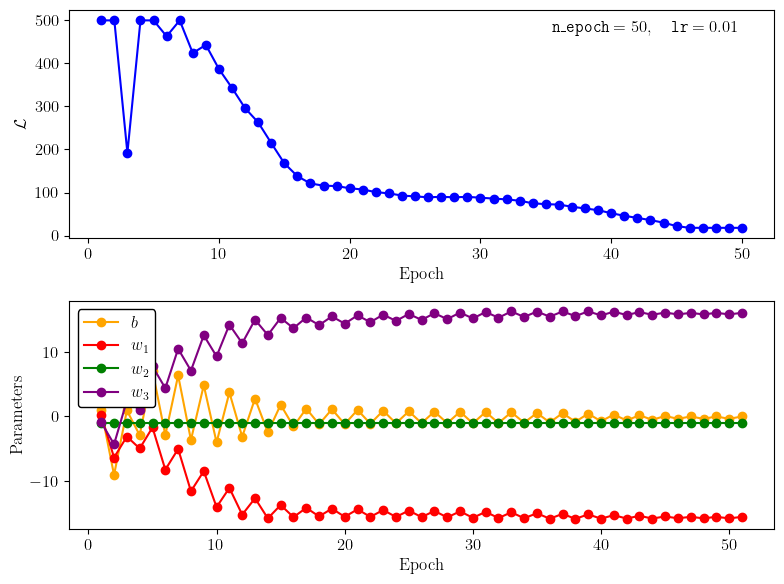

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Initialize epoch axis for plotting
epoch_axis = np.arange(1, n_epochs + 1)
# Plot the loss as a function of epoch
ax1.plot(epoch_axis, loss_hist, marker='o', color='blue')

# Set labels for ax1
ax1.set_xlabel("Epoch")
ax1.set_ylabel(r"$\mathcal{L}$")
# Place hyperparameters as text in the top right corner
ax1.text(0.95, 0.95, rf"$\mathtt{{n\_epoch}} = {n_epochs}, \quad \mathtt{{lr}} = {learning_rate}$", transform=ax1.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')

# Plot the perceptron parameters as a function of epoch
epoch_axis = np.arange(1, n_epochs + 2)
ax2.plot(epoch_axis, bias_hist, marker='o', color='orange', label="$b$")
ax2.plot(epoch_axis, [w[0] for w in weight_hist], marker='o', color='red', label="$w_1$")
ax2.plot(epoch_axis, [w[1] for w in weight_hist], marker='o', color='green', label="$w_2$")
ax2.plot(epoch_axis, [w[2] for w in weight_hist], marker='o', color='purple', label="$w_3$")

# Set labels and legend for ax2
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Parameters")
ax2.legend(framealpha=1.0, edgecolor = 'black')
fig.tight_layout()

Performance on validation set: 98.60% accuracy


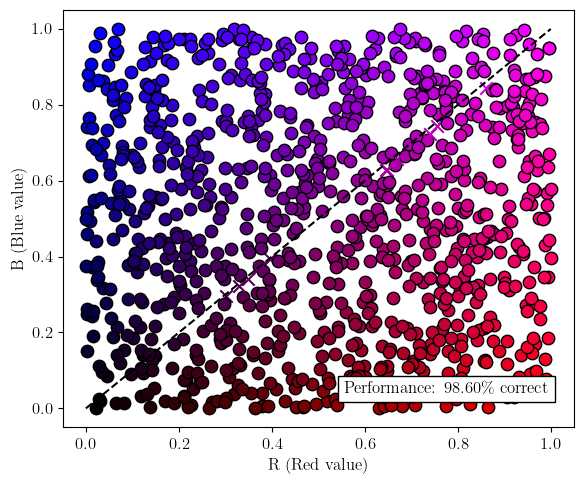

In [12]:
# Evaluate the performance on a new data sample
validation = RB_dataset(1000, seed = 142)

# Run through the network and evaluate performance (track the performance for plotting)
performance = []
for i in range(validation.shape[0]):
    x1, x2, x3, label = validation[i]
    prediction = perceptron(Scalar(x1), Scalar(x2), Scalar(x3), 
                            weights[0], weights[1], weights[2], bias)
    
    # Output 1 if correct, 0 if incorrect
    performance.append(1 if prediction.data == label else 0)

# Print the performance as a total percentage
performance_percentage = np.mean(performance) * 100
print(f"Performance on validation set: {performance_percentage:.2f}% accuracy")

# Plot RB values and performance
fig, ax = plt.subplots(figsize=(6, 5))
for i in range(validation.shape[0]):
    x1, x2, x3, label = validation[i]
    color = (x1, x2, x3)
    marker = 'o' if performance[i] == 1 else 'x'
    if performance[i] == 1:
        ax.scatter(x1, x3, c=[color], marker=marker, s=80, edgecolor='k')
    else:
        ax.scatter(x1, x3, c=[color], marker=marker, s=80)

# Include the performance percentage as a text annotation
ax.text(0.55, 0.075, rf"Performance: {performance_percentage:.2f}\% correct",
        transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=1.0, edgecolor='black'))

# Plot R = B boundary
min_val = min(validation[:, 0].min(), validation[:, 2].min())
max_val = max(validation[:, 0].max(), validation[:, 2].max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='R = B')
ax.set_xlabel("R (Red value)")
ax.set_ylabel("B (Blue value)")

fig.tight_layout()


### Exercise

Play with the network hyperparameters (learning rate and number of epochs) to get a feel for what optimal values may be. What learning rate parameter is too large? Too small? Describe an optimization procedure using the training metric and analysis techniques that can help you choose the optimal values.

In [4]:
###START_EXERCISE
# Your answer here
###STOP_EXERCISE

In [3]:
###START_SOLUTION
###STOP_SOLUTION

## A more structured implementation

Let's build out a `Perceptron` class in a slightly more structured way such that we can recursively build up **layers** of perceptrons.

We'll also replace the step final function by a `tanh` to add a smoother gradient.

In [30]:
class Perceptron():
    def __init__(self, input_size, activate = True):
        self.activate = activate
        self.weights = [Scalar(random.uniform(-1, 1), label=f"w{i}") for i in range(1,input_size+1)]
        self.bias    = Scalar(random.uniform(-1, 1), label="b")

    def __call__(self, inputs):
        weighted_sum = sum([w * x for w, x in zip(self.weights, inputs)], self.bias)
        if self.activate: return weighted_sum.tanh()
        else: return weighted_sum

Scalar(0.5891608229628941, grad = 0.0)


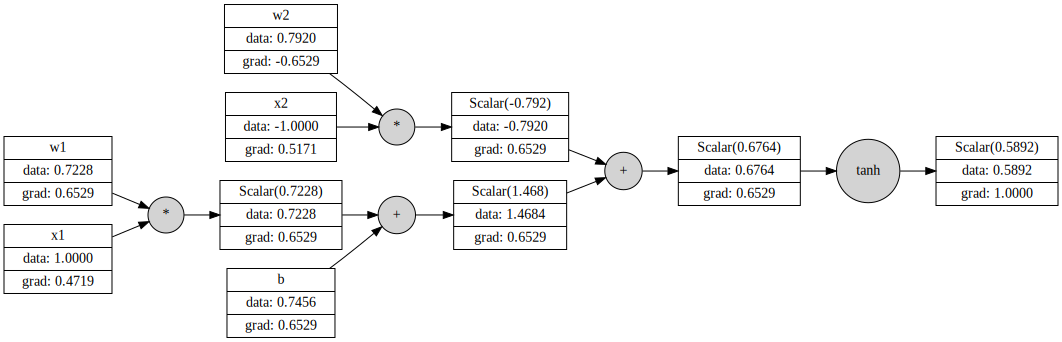

In [31]:
# Initialize the perceptron with 2 inputs
p = Perceptron(2)
# Example input vector with 2 scalars
x = [Scalar(1.0, label = "x1"), Scalar(-1.0, label = "x2")]
# Forward pass through the perceptron
p_forward = p(x)
print(p_forward)
# Backward pass
p_forward.backward()
# Visualize the computation graph
p_forward.visualize_graph()

In [32]:
class Layer():
    def __init__(self, n_perceptrons, input_size, activate = True):
        self.perceptrons = [Perceptron(input_size, activate) for _ in range(n_perceptrons)]

    def __call__(self, inputs):
        return [p(inputs) for p in self.perceptrons]

[Scalar(0.8028575833429692, grad = 0.0), Scalar(-0.8441962361175522, grad = 0.0)]


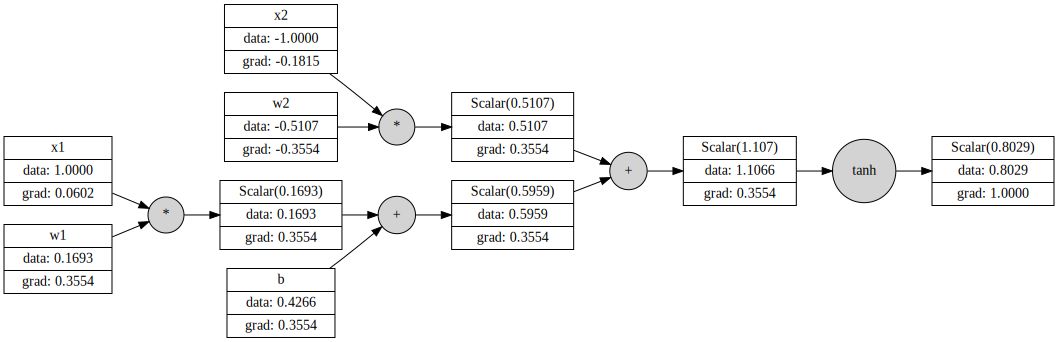

In [33]:
# Set layer parameters
n_perceptrons = 2
input_size    = 2

l = Layer(n_perceptrons = n_perceptrons, input_size = input_size)
# Example input vector with 3 scalars
x = [Scalar(1.0, label = "x1"), Scalar(-1.0, label = "x2")]
# Forward pass through the layer
l_forward = l(x)
# Print the output of the layer
print(l_forward)
# Backward pass (for the first perceptron in the layer)
l_forward[0].backward()
# Visualize the computation graph for the first perceptron in the layer
l_forward[0].visualize_graph()

## Multi-layer perceptrons


While a single perceptron can only model simple linear decision boundaries, the true power of neural networks emerges when we stack perceptrons together into layers, forming what is known as a **multi-layer perceptron** (MLP). By composing multiple layers of perceptrons we enable the network to learn and represent highly complex, nonlinear functions - this makes MLPs the foundational building block for most modern neural networks.

In this case, we build the last layer without an activation function.

In [36]:
class MultiLayerPerceptron():
    def __init__(self, n_inputs, n_outputs, n_hidden_layers = 1, n_perceptrons_per_layer = 5):
        self.layers = []
        # Input layer
        self.layers.append(Layer(n_perceptrons_per_layer, n_inputs))
        # Hidden layers
        for _ in range(n_hidden_layers - 1):
            self.layers.append(Layer(n_perceptrons_per_layer, n_perceptrons_per_layer))
        # Output layer (with no activation function)
        self.layers.append(Layer(n_outputs, n_perceptrons_per_layer, activate = False))

    def __call__(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
        if len(inputs) == 1: return inputs[0]
        else: return inputs

[Scalar(-0.632099301126083, grad = 0.0), Scalar(-1.9127359501353998, grad = 0.0), Scalar(-0.27676546022850573, grad = 0.0), Scalar(-0.6019507192824446, grad = 0.0), Scalar(1.7068805953136839, grad = 0.0)]
inputs y: [Scalar(1.0, grad = 147.28297964862617), Scalar(2.0, grad = -228.67441184592252), Scalar(-5.0, grad = -70.2280538341434), Scalar(-3.0, grad = -24.516038789743703)]


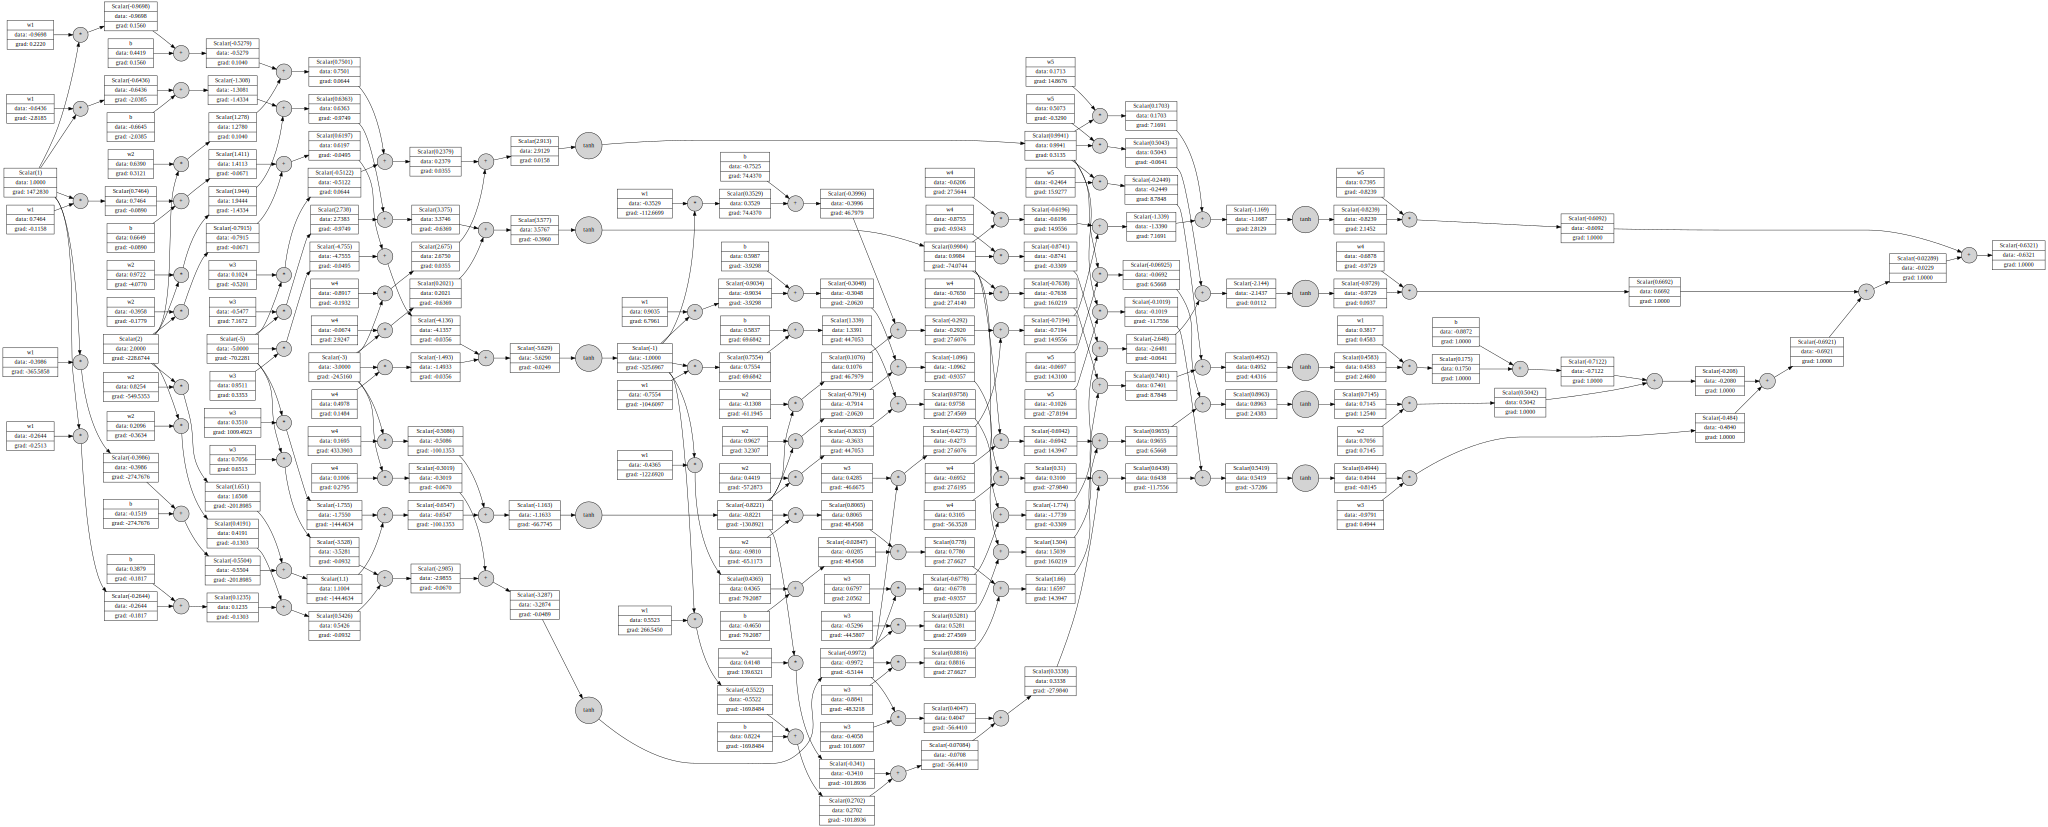

In [37]:
# Set architecture parameters
n_inputs                = 4
n_outputs               = 5
n_hidden_layers         = 2
n_perceptrons_per_layer = 5

# Initialize the multi-layer perceptron
mlp = MultiLayerPerceptron(n_inputs = n_inputs, n_outputs = n_outputs, 
                           n_hidden_layers = n_hidden_layers, 
                           n_perceptrons_per_layer = n_perceptrons_per_layer
                           )

# Example input vector with 4 scalars
y = [Scalar(1.0), Scalar(2.0), Scalar(-5.0), Scalar(-3.0)]
# Forward pass through the multi-layer perceptron
mlp_forward = mlp(y)
print(mlp_forward)
# Backward pass through the multi-layer perceptron
if n_outputs == 1: 
    mlp_forward.backward()
    # Print inputs after the backward pass
    print('Input y:', y)
else: 
    for output in mlp_forward:
        output.backward()
    # Print inputs after the backward pass
    print('inputs y:', y)
    # For visualization purposes
    mlp_forward = mlp_forward[0]

# Visualize the computation graph for one the multi-layer perceptron
mlp_forward.visualize_graph()

## Exercise


Write a function in `MultiLayerPerceptron` that will compute and return the total number of parameters in the network.

How many parameters does the following network have?

```
n_inputs                = 64
n_outputs               = 1
n_hidden_layers         = 23
n_perceptrons_per_layer = 10
```

In [4]:
###START_EXERCISE
# Your answer here
###STOP_EXERCISE

In [3]:
###START_SOLUTION
###STOP_SOLUTION

## Classifying a <font color="red">c</font><font color="magenta">o</font><font color="blue">l</font><font color="cyan">o</font><font color="green">r</font> <font color="yellow">w</font><font color="black">h</font><font color="white">e</font><font color="red">e</font><font color="magenta">l</font>

Now we want to use the power of our newly built MLPs to learn a much harder task than the red-blue binary classification learned above.

The goal is to train a neural network to distinguish between eight different color classes based on their RGB values: **<font color="red">Red</font>, <font color="green">Green</font>, <font color="blue">Blue</font>, <font color="yellow">Yellow</font>, <font color="cyan">Cyan</font>, <font color="magenta">Magenta</font>, <font color="white">White</font>,** and **<font color="black">Black</font>**. To do this, we generate a synthetic dataset of random RGB triplets, each normalized to the range $[0, 1]$. Each color sample is assigned a label according to simple rules (see below) that capture the essence of these color categories (for example, "white" if all channels are high, "black" if all are low, "yellow" if red and green are high but blue is low, etc.). This dataset provides a challenging multi-class problem for our MLP, requiring it to learn nonlinear boundaries in the RGB color cube.

In [38]:
import numpy as np

def RGB_dataset(num_samples=10000, seed=None):
    """
    Create a dataset of normalized RGB values and labels assigned to 8 classes:
    Red, Green, Blue, Yellow, Cyan, Magenta, White, Black.
    """
    if seed is not None: np.random.seed(seed)

    # Generate random RGB values
    R = np.random.random(num_samples)
    G = np.random.random(num_samples)
    B = np.random.random(num_samples)

    # Initialize labels
    labels = np.zeros(num_samples, dtype=int)

    # Class conditions (priority matters if overlapping)
    for i in range(num_samples):
        r, g, b = R[i], G[i], B[i]
        if r > 0.7 and g > 0.7 and b > 0.7:
            labels[i] = 6  # White
        elif r < 0.3 and g < 0.3 and b < 0.3:
            labels[i] = 7  # Black
        elif r > 0.5 and g > 0.5 and b < 0.5:
            labels[i] = 3  # Yellow
        elif g > 0.5 and b > 0.5 and r < 0.5:
            labels[i] = 4  # Cyan
        elif r > 0.5 and b > 0.5 and g < 0.5:
            labels[i] = 5  # Magenta
        elif r > g and r > b and g < 0.5 and b < 0.5:
            labels[i] = 0  # Red
        elif g > r and g > b and r < 0.5 and b < 0.5:
            labels[i] = 1  # Green
        elif b > r and b > g and r < 0.5 and g < 0.5:
            labels[i] = 2  # Blue
        else:
            labels[i] = np.argmax([r, g, b])  # fallback in case of ambiguity

    # Stack into dataset
    RGB = np.column_stack((R, G, B, labels))

    # Shuffle
    indices = np.random.permutation(num_samples)
    RGB = RGB[indices]

    return RGB

In [39]:
num_samples = 10000
RGB = RGB_dataset(num_samples, seed=42)

# Get a feel for the dataset
print('Dataset shape:', RGB.shape)
print('RGB value:', RB[0, 0:3], '\nLabel:', RGB[0, 3])
print('R:', RB[0, 0], 'G:', RB[0, 1], 'B:', RGB[0, 2])
print('First 10 elements of dataset:\n', RGB[:10])

Dataset shape: (10000, 4)
RGB value: [0.96502691 0.         0.69503523] 
Label: 0.0
R: 0.9650269106665126 G: 0.0 B: 0.6347445187232444
First 10 elements of dataset:
 [[0.94319585 0.53941819 0.63474452 0.        ]
 [0.69361806 0.51764809 0.12455539 3.        ]
 [0.62470067 0.31137634 0.69554758 5.        ]
 [0.70113959 0.22719125 0.57711716 5.        ]
 [0.66314783 0.25125916 0.67997607 5.        ]
 [0.86909907 0.71528213 0.1290289  3.        ]
 [0.93831573 0.0116266  0.38620292 0.        ]
 [0.20951922 0.7605322  0.81023946 4.        ]
 [0.1466083  0.94824454 0.74689834 4.        ]
 [0.37819635 0.65601458 0.48799037 1.        ]]


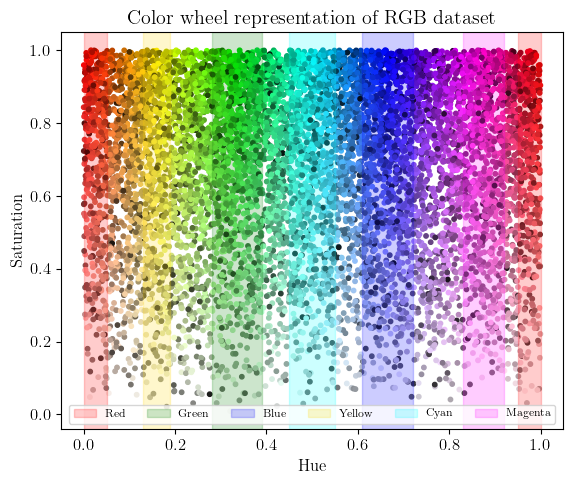

In [40]:
# import colors
import matplotlib.colors as mcolors
# Visualize the dataset on a color wheel instead
fig, ax = plt.subplots(figsize=(6, 5))
   
# Normalize RGB values to [0, 1]
R = RGB[:, 0]
G = RGB[:, 1]
B = RGB[:, 2]

# Convert RGB to HSV
hsv = np.array([mcolors.rgb_to_hsv([r, g, b]) for r, g, b in zip(R, G, B)])

# Plot the color wheel
ax.scatter(hsv[:, 0], hsv[:, 1], c=RGB[:, :3], s=10)
# Set labels and title
ax.set_xlabel("Hue")
ax.set_ylabel("Saturation")
ax.set_title("Color wheel representation of RGB dataset")

# Add boundaries for each label in HSV space
# We'll use the same logic as in RGB_dataset for the boundaries

# For chromatic colors, boundaries are in hue
# Red: hue near 0 or 1, S > 0.5, V > 0.3
ax.axvspan(0.95, 1.0, color='red', alpha=0.2, label='Red')
ax.axvspan(0.0, 0.05, color='red', alpha=0.2)
# Green: hue ~1/3
ax.axvspan(0.28, 0.39, color='green', alpha=0.2, label='Green')
# Blue: hue ~2/3
ax.axvspan(0.61, 0.72, color='blue', alpha=0.2, label='Blue')
# Yellow: hue ~1/6
ax.axvspan(0.13, 0.19, color='gold', alpha=0.2, label='Yellow')
# Cyan: hue ~0.5
ax.axvspan(0.45, 0.55, color='cyan', alpha=0.2, label='Cyan')
# Magenta: hue ~5/6
ax.axvspan(0.83, 0.92, color='magenta', alpha=0.2, label='Magenta')

ax.legend(loc='lower center', fontsize=8, ncols = 6)

fig.tight_layout()

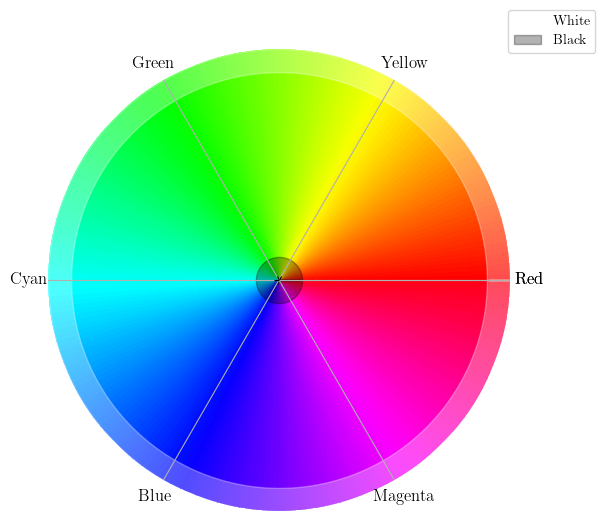

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mpl

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))

norm = mpl.colors.Normalize(0.0, 2*np.pi)

quant_steps = 2056
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap = mpl.colormaps['hsv'],
    norm = norm,
    orientation = 'horizontal'
)

cb.outline.set_visible(False)

#ax.set_yticks([0, 0.5, 1.0])
#ax.set_yticklabels(['0', '0.5', '1.0'])
ax.set_xticks(np.linspace(0, 2 * np.pi, 7))
ax.set_xticklabels(['Red', 'Yellow', 'Green', 'Cyan', 'Blue', 'Magenta', 'Red'])


# White and Black are not hue-dependent, but can be shown as inner/outer rings
# White: high radius (saturation low, value high)
ax.fill_between(np.linspace(0, 2*np.pi, 200), 0.9, 1.0, color='white', alpha=0.3, label='White')
# Black: low radius (value low)
ax.fill_between(np.linspace(0, 2*np.pi, 200), 0.0, 0.1, color='black', alpha=0.3, label='Black')

# Optional: add a legend for the boundaries
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=10)

## Exercise

Solve the multi-class classification problem posed above by constructing and training an MLP (using the dataset produced above). Here are some useful checkpoints along this journey:

1. Following the `classify.ipynb` tutorial, first implement a `SoftMax` method in `Scalar`: this function will take the raw **logit** output from the final MLP layer (notice how, by default, we defined the last layer of our MLP to not activate)
   $$\hat{p}_{i,y_i} \equiv \texttt{SoftMax}(\textbf{z})_{y_i} = \frac{\exp(z_{i,y_i})}{\sum_j \exp(z_{i,j})}$$
   where $z_{i,j}$ is $j$-th logit output from the MLP for the $i$-th data sample and $z_{i,y_i}$ corresponds to the logit in the position of the correct label $y_i$ of the $i$-th sample.
2. Write up the cross-entropy loss
   $$\mathcal{L}_i = - \log(\hat{p}_{i,y_i}) = -z_{i,y_i} + \log\left(\sum_j \exp(z_{i,j})\right)$$
where $\hat{p}$ is the predicted probability for the sample $i$ computed using the `SoftMax` function from above and $\textbf{z}[\texttt{id}(y_i)]$ is the output logit in the position corresponding to the true label of the $i$-th sample. Equivalently, in a slightly more unconventional notation:
$$\mathcal{L}_i = - \log(\hat{p}\left({\textbf{z}[\texttt{id}(y_i)]}\right) = -\textbf{z}[\texttt{id}(y_i)] + \log\left(\sum_j \exp(z_{i,j})\right).$$
3. Implement a training loop for the MLP.
4. Train, validate, and assess the performance of the network.

In [4]:
###START_EXERCISE
# Your answer here
###STOP_EXERCISE

In [3]:
###START_SOLUTION
###STOP_SOLUTION

# **The neural network zoo**

### **Challenge**
Take a look at these websites:

[https://www.asimovinstitute.org/neural-network-zoo-prequel-cells-layers/](https://www.asimovinstitute.org/neural-network-zoo-prequel-cells-layers/)

[https://www.asimovinstitute.org/neural-network-zoo/](https://www.asimovinstitute.org/neural-network-zoo/)

Choose a network and implement it from scratch using the `Scalar` engine.